
Photon Counts for Different Exposure Times:
Exposure Time: 1 seconds -> Photon Count: 1.02e-18 photons
Exposure Time: 100 seconds -> Photon Count: 1.02e-16 photons
Exposure Time: 1000 seconds -> Photon Count: 1.02e-15 photons
Exposure Time: 10000 seconds -> Photon Count: 1.02e-14 photons


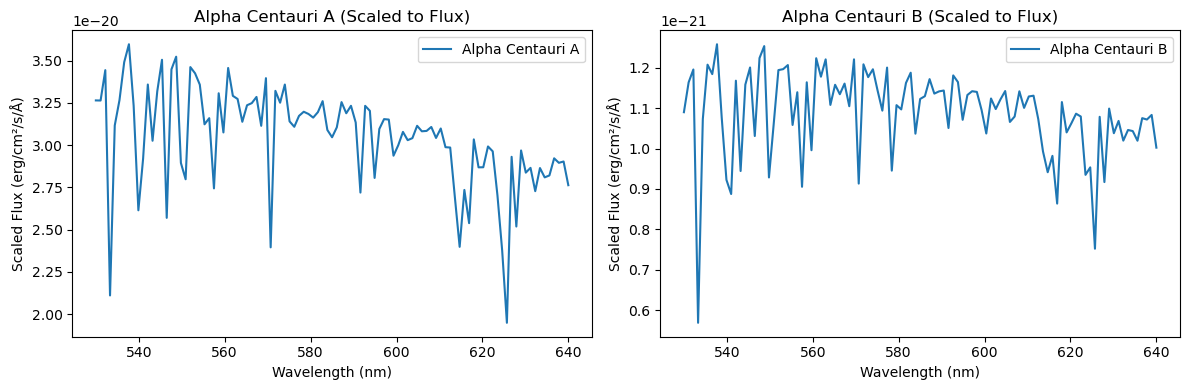

In [2]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import pysynphot as S

# Constants
h = 6.626e-34  # Planck's constant, J*s
c = 3.0e8      # Speed of light, m/s
f0_V = 3.63e-20  # Reference flux for magnitude 0 in the V band (erg/cm²/s/Å)
f0_K1V = 4.283e-21  # Reference flux for magnitude 0 in the K1V band (erg/cm²/s/Å)

# Stellar properties for Alpha Centauri A and B
ALPHA_CEN_A = {"temp": 5770.0, "metal": 0.2, "grav": 4.0}
ALPHA_CEN_B = {"temp": 5350.0, "metal": 0.23, "grav": 4.37}

# Apparent magnitudes for Alpha Centauri A and B
magnitude_A = 0.01  # Alpha Centauri A apparent magnitude in V band
magnitude_B = 1.33  # Alpha Centauri B apparent magnitude in K1V band

def get_normalized_spectrum(star_props, wavelengths):
    """Retrieve and normalize spectrum for a star."""
    spectrum = S.Icat("phoenix", star_props["temp"], star_props["metal"], star_props["grav"])
    spectrum.convert('flam')  # Convert to flux per unit area
    spectrum.convert('m')     # Convert to flux per unit wavelength
    sampled_spectrum = spectrum.sample(wavelengths)
    return sampled_spectrum / sampled_spectrum.max()

def scale_spectrum_to_flux(normalized_spectrum, wavelengths, magnitude, reference_flux):
    """Scale normalized spectrum to match known flux from apparent magnitude."""
    scale_factor = 10 ** (-magnitude / 2.5)
    scaled_spectrum = normalized_spectrum * (reference_flux * scale_factor)
    return scaled_spectrum

# Define wavelength grid for TOLIMAN bandpass (530-640 nm)
spec_wavelengths = np.linspace(530e-9, 640e-9, 101)

# Generate normalized spectra for Alpha Centauri A and B
Aspec = get_normalized_spectrum(ALPHA_CEN_A, spec_wavelengths)
Bspec = get_normalized_spectrum(ALPHA_CEN_B, spec_wavelengths)

# Scale the spectra according to the apparent magnitudes of the stars
scaled_A = scale_spectrum_to_flux(Aspec, spec_wavelengths, magnitude_A, f0_V)
scaled_B = scale_spectrum_to_flux(Bspec, spec_wavelengths, magnitude_B, f0_K1V)

# Define TOLIMAN bandpass (530-640 nm)
tol_bandpass = S.Box(585, 110)  # Center = 585 nm, Width = 110 nm

# Calculate photon flux (photons/cm²/s/Å) from flux using Planck's relation
def flux_to_photon_flux(flux, wavelengths):
    """Convert flux to photon flux (photons/cm²/s/Å)."""
    return flux * wavelengths * 1e-10 / (h * c)

# Convert the scaled spectra to photon flux (photons/cm²/s/Å)
A_photon_flux = flux_to_photon_flux(scaled_A, spec_wavelengths)
B_photon_flux = flux_to_photon_flux(scaled_B, spec_wavelengths)

# Calculate total photon flux (photons/cm²/s) by integrating the photon flux
total_photon_flux_A = np.trapezoid(A_photon_flux, spec_wavelengths)
total_photon_flux_B = np.trapezoid(B_photon_flux, spec_wavelengths)

# Total photon flux from both stars
total_photon_flux = total_photon_flux_A + total_photon_flux_B

# Define exposure times (in seconds)
exposure_times = [1, 100, 1000, 10000]  # seconds

# Calculate photon counts for different exposure times
photon_counts = [total_photon_flux * t for t in exposure_times]

# Display results for photon counts
print("\nPhoton Counts for Different Exposure Times:")
for t, count in zip(exposure_times, photon_counts):
    print(f"Exposure Time: {t} seconds -> Photon Count: {count:.2e} photons")

# Plot Alpha Centauri A and B spectra (scaled)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Alpha Centauri A (Scaled to Flux)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scaled Flux (erg/cm²/s/Å)")
plt.plot(spec_wavelengths * 1e9, scaled_A, label="Alpha Centauri A")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Alpha Centauri B (Scaled to Flux)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scaled Flux (erg/cm²/s/Å)")
plt.plot(spec_wavelengths * 1e9, scaled_B, label="Alpha Centauri B")
plt.legend()

plt.tight_layout()
plt.show()
